## Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
#collecting 10 yrs of stock data
start = '2013-12-01'
end = '2023-12-19'

stock = 'GOOG'

df=pd.DataFrame(yf.download(stock,start,end))

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.to_csv('data.csv')

In [4]:
df=pd.read_csv('data.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-02,26.488464,26.559200,26.170904,26.263557,26.263557,55133884
1,2013-12-03,26.175636,26.486721,26.127567,26.233171,26.233171,67295297
2,2013-12-04,26.186098,26.500172,26.151976,26.355713,26.355713,47842656
3,2013-12-05,26.331305,26.392574,26.179125,26.334791,26.334791,45517975
4,2013-12-06,26.644878,26.650108,26.403034,26.646872,26.646872,57366220


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2524,2023-12-12,133.270004,134.539993,132.830002,133.639999,133.639999,26584000
2525,2023-12-13,134.544998,134.779999,132.949997,133.970001,133.970001,25414500
2526,2023-12-14,134.770004,135.035004,131.059998,133.199997,133.199997,29619100
2527,2023-12-15,132.919998,134.830002,132.630005,133.839996,133.839996,58569400
2528,2023-12-18,133.860001,138.380005,133.770004,137.190002,137.190002,25687300


In [7]:
df1=df.reset_index()['Close']

In [8]:
df1

0        26.263557
1        26.233171
2        26.355713
3        26.334791
4        26.646872
           ...    
2524    133.639999
2525    133.970001
2526    133.199997
2527    133.839996
2528    137.190002
Name: Close, Length: 2529, dtype: float64

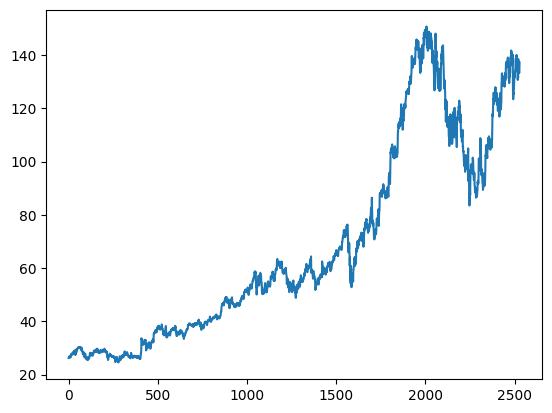

In [9]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [10]:
#LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
print(df1)

[[0.01350378]
 [0.01326291]
 [0.01423431]
 ...
 [0.86120372]
 [0.86627708]
 [0.89283304]]


In [15]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [16]:
training_size,test_size

(1643, 886)

In [17]:
train_data

array([[0.01350378],
       [0.01326291],
       [0.01423431],
       ...,
       [0.382468  ],
       [0.38630873],
       [0.36173063]])

In [18]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [19]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [20]:
print(X_train.shape), print(y_train.shape)

(1542, 100)
(1542,)


(None, None)

In [21]:
print(X_test.shape), print(ytest.shape)

(785, 100)
(785,)


(None, None)

In [22]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [23]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [24]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 [==============================] - 44s 839ms/step - loss: 0.0053 - val_loss: 0.0208
Epoch 2/100
25/25 [==============================] - 15s 601ms/step - loss: 5.0886e-04 - val_loss: 0.0068
Epoch 3/100
25/25 [==============================] - 14s 552ms/step - loss: 3.2517e-04 - val_loss: 0.0044
Epoch 4/100
25/25 [==============================] - 13s 538ms/step - loss: 3.2312e-04 - val_loss: 0.0081
Epoch 5/100
25/25 [==============================] - 14s 544ms/step - loss: 3.0564e-04 - val_loss: 0.0146
Epoch 6/100
25/25 [==============================] - 14s 555ms/step - loss: 3.4417e-04 - val_loss: 0.0082
Epoch 7/100
25/25 [==============================] - 13s 511ms/step - loss: 2.8300e-04 - val_loss: 0.0063
Epoch 8/100
25/25 [==============================] - 13s 536ms/step - loss: 2.7148e-04 - val_loss: 0.0112
Epoch 9/100
25/25 [==============================] - 13s 505ms/step - loss: 2.8443e-04 - val_loss: 0.0092
Epoch 10/100
25/25 [==============================

25/25 [==============================] - 15s 584ms/step - loss: 9.2689e-05 - val_loss: 0.0267
Epoch 78/100
25/25 [==============================] - 15s 610ms/step - loss: 9.9093e-05 - val_loss: 0.0224
Epoch 79/100
25/25 [==============================] - 15s 603ms/step - loss: 8.1492e-05 - val_loss: 0.0287
Epoch 80/100
25/25 [==============================] - 16s 656ms/step - loss: 8.4441e-05 - val_loss: 0.0404
Epoch 81/100
25/25 [==============================] - 16s 644ms/step - loss: 9.4857e-05 - val_loss: 0.0233
Epoch 82/100
25/25 [==============================] - 16s 666ms/step - loss: 8.7191e-05 - val_loss: 0.0269
Epoch 83/100
25/25 [==============================] - 15s 618ms/step - loss: 8.3649e-05 - val_loss: 0.0163
Epoch 84/100
25/25 [==============================] - 15s 587ms/step - loss: 7.8891e-05 - val_loss: 0.0265
Epoch 85/100
25/25 [==============================] - 16s 664ms/step - loss: 8.4867e-05 - val_loss: 0.0230
Epoch 86/100
25/25 [==============================

In [30]:
#Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

25/25 [==============================] - 3s 100ms/step


In [31]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [32]:
#Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

47.52189764269983

In [33]:
#Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

108.21839437592158

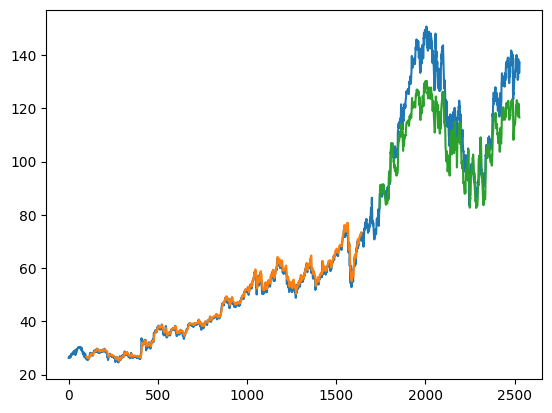

In [34]:
#Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [35]:
l=len(test_data)

In [36]:
x_input=test_data[l-100:].reshape(1,-1)
x_input.shape


(1, 100)

In [37]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [38]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.7514923]
101
1 day input [0.8604903  0.85081918 0.82505598 0.82608655 0.82426322 0.85121557
 0.8504228  0.83702592 0.83750165 0.8371845  0.85034358 0.83797726
 0.82878175 0.83948343 0.82085461 0.8273548  0.8333795  0.86128306
 0.83916628 0.84130664 0.85002642 0.87935693 0.89077191 0.89410141
 0.88974146 0.88902805 0.87840559 0.88498513 0.89291227 0.89719299
 0.88395468 0.89529043 0.90710191 0.90163217 0.90686411 0.90583354
 0.87222243 0.84661781 0.84574582 0.85303877 0.83147695 0.84741057
 0.86064888 0.85050215 0.87682019 0.86199648 0.88554009 0.8833205
 0.90504078 0.91114471 0.90876655 0.92858439 0.9174071  0.90385176
 0.91899262 0.92295619 0.90940073 0.90702256 0.88926585 0.89846124
 0.9160595  0.80943951 0.78383489 0.7835178  0.80214656 0.79857937
 0.81657395 0.82458038 0.8387699  0.84733122 0.85486198 0.86167932
 0.84923378 0.86802106 0.86469168 0.8788812  0.88641208 0.90480298
 0.89085126 0.89861982 0.90416879 0.91526686 0.90099798 0.89965038
 0.90416879 0.88657053 0.86691126 0

8 day output [[0.03150922]]
9 day input [0.83750165 0.8371845  0.85034358 0.83797726 0.82878175 0.83948343
 0.82085461 0.8273548  0.8333795  0.86128306 0.83916628 0.84130664
 0.85002642 0.87935693 0.89077191 0.89410141 0.88974146 0.88902805
 0.87840559 0.88498513 0.89291227 0.89719299 0.88395468 0.89529043
 0.90710191 0.90163217 0.90686411 0.90583354 0.87222243 0.84661781
 0.84574582 0.85303877 0.83147695 0.84741057 0.86064888 0.85050215
 0.87682019 0.86199648 0.88554009 0.8833205  0.90504078 0.91114471
 0.90876655 0.92858439 0.9174071  0.90385176 0.91899262 0.92295619
 0.90940073 0.90702256 0.88926585 0.89846124 0.9160595  0.80943951
 0.78383489 0.7835178  0.80214656 0.79857937 0.81657395 0.82458038
 0.8387699  0.84733122 0.85486198 0.86167932 0.84923378 0.86802106
 0.86469168 0.8788812  0.88641208 0.90480298 0.89085126 0.89861982
 0.90416879 0.91526686 0.90099798 0.89965038 0.90416879 0.88657053
 0.86691126 0.86215505 0.84083103 0.85478275 0.84717265 0.90282119
 0.88847309 0.87309442

15 day output [[-0.03103129]]
16 day input [ 0.8273548   0.8333795   0.86128306  0.83916628  0.84130664  0.85002642
  0.87935693  0.89077191  0.89410141  0.88974146  0.88902805  0.87840559
  0.88498513  0.89291227  0.89719299  0.88395468  0.89529043  0.90710191
  0.90163217  0.90686411  0.90583354  0.87222243  0.84661781  0.84574582
  0.85303877  0.83147695  0.84741057  0.86064888  0.85050215  0.87682019
  0.86199648  0.88554009  0.8833205   0.90504078  0.91114471  0.90876655
  0.92858439  0.9174071   0.90385176  0.91899262  0.92295619  0.90940073
  0.90702256  0.88926585  0.89846124  0.9160595   0.80943951  0.78383489
  0.7835178   0.80214656  0.79857937  0.81657395  0.82458038  0.8387699
  0.84733122  0.85486198  0.86167932  0.84923378  0.86802106  0.86469168
  0.8788812   0.88641208  0.90480298  0.89085126  0.89861982  0.90416879
  0.91526686  0.90099798  0.89965038  0.90416879  0.88657053  0.86691126
  0.86215505  0.84083103  0.85478275  0.84717265  0.90282119  0.88847309
  0.87309

22 day output [[0.10309616]]
23 day input [ 0.89077191  0.89410141  0.88974146  0.88902805  0.87840559  0.88498513
  0.89291227  0.89719299  0.88395468  0.89529043  0.90710191  0.90163217
  0.90686411  0.90583354  0.87222243  0.84661781  0.84574582  0.85303877
  0.83147695  0.84741057  0.86064888  0.85050215  0.87682019  0.86199648
  0.88554009  0.8833205   0.90504078  0.91114471  0.90876655  0.92858439
  0.9174071   0.90385176  0.91899262  0.92295619  0.90940073  0.90702256
  0.88926585  0.89846124  0.9160595   0.80943951  0.78383489  0.7835178
  0.80214656  0.79857937  0.81657395  0.82458038  0.8387699   0.84733122
  0.85486198  0.86167932  0.84923378  0.86802106  0.86469168  0.8788812
  0.88641208  0.90480298  0.89085126  0.89861982  0.90416879  0.91526686
  0.90099798  0.89965038  0.90416879  0.88657053  0.86691126  0.86215505
  0.84083103  0.85478275  0.84717265  0.90282119  0.88847309  0.87309442
  0.86469168  0.86730765  0.86120372  0.86627708  0.89283304  0.75149232
  0.6866852

In [39]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [40]:
import matplotlib.pyplot as plt

In [41]:
l2=len(df1)

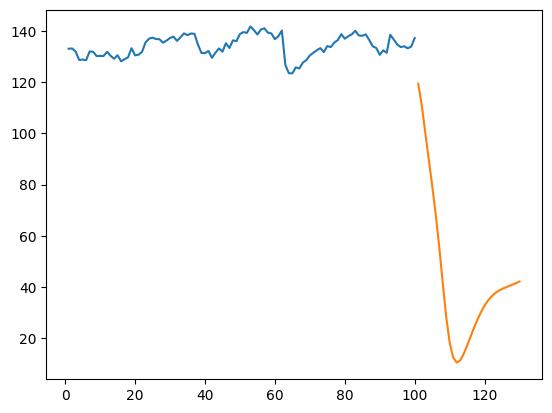

In [42]:
plt.plot(day_new,scaler.inverse_transform(df1[l2-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

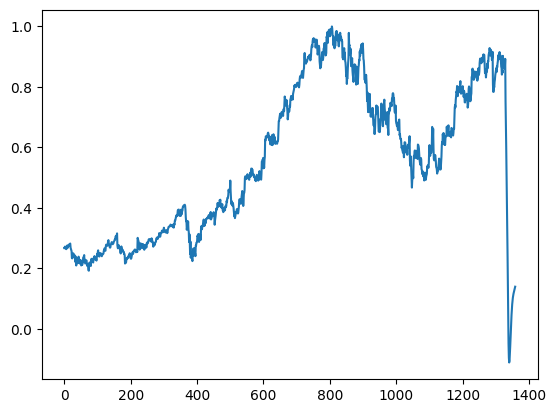

In [43]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [44]:
df3=scaler.inverse_transform(df3).tolist()

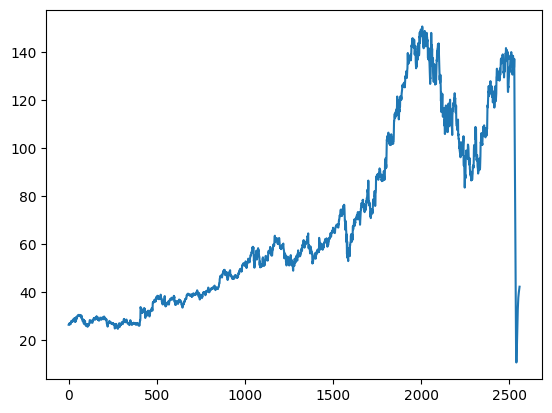

In [45]:
plt.plot(df3)